This is notebook is based on [CassavaLeaf ViT baseline Notebook](https://www.kaggle.com/szuzhangzhi/vision-transformer-vit-cuda-as-usual) and Adjusted for Plant pathology 2021 dataset.

Обычно картинку используют как 3D array (высота, ширина, количество каналов) и применяется к ним сверточные слои. Но тут есть ряд недостатков:

- не все пиксели одинаково полезны;
- свертки не достаточно хорошо работают с пикселями, находящимися далеко друг от друга;
- свертки недостаточно эффективны в очень глубоких нейронных сетях.

В результате авторы предлагают конвертировать изображения в визуальные токены и подавать их в трансформер.

- Вначале используется обычный backbone для получения feature maps
- Далее feature map конвертируется в визуальные токены
- Токены подаются в трансформеры
- Выход трансформера может использоваться для задач классификации
- А если объединить выход трансформера с feature map, то можно получить предсказания для задач сегментации

Self-Attention между пикселями. К примеру, если картинка размера 640x640, модельке надо посчитать self-attention для 409к комбинаций. Но вероятней всего, самый верхний правый пиксель вряд ли будет иметь значимое влияние на нижний левый пиксель. ViT справился с этой проблемой за счет сегментации картинки на маленькие патчи (к примеру, 16x16).

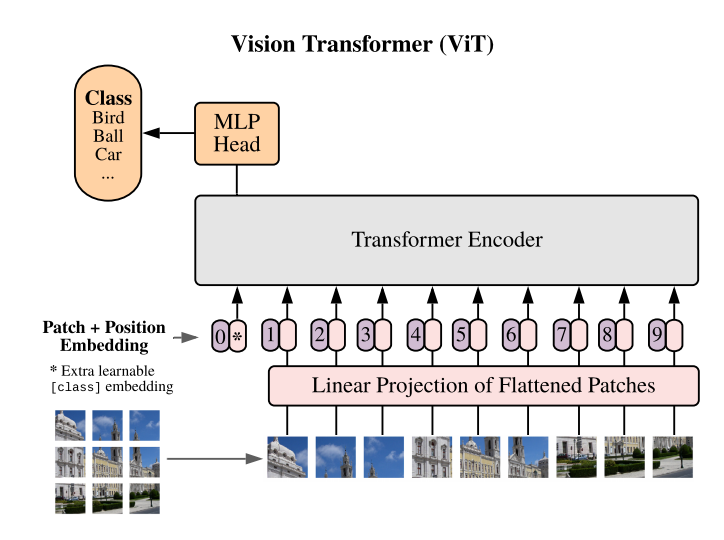

1. Изображение нужно поделить на пачти фиксированного размера

Есть 2D картинка размера  H * W, которая может разделиться на N патчей, где $N=\frac{H * W}{P^2}$. Если картинка 48x48, размер патча 16x16, то получится $N=\frac{48 * 48}{16^2} = 9$.

In [ ]:
from scipy import misc
import matplotlib.pyplot as plt


img = misc.face()  #  1024 x 768, color image of a raccoon face
plt.imshow(img);

In [ ]:
import cv2
img = cv2.resize(img, (224, 224))
plt.imshow(img);

In [ ]:
p = 16
h, w = img.shape[:2]

fig, ax = plt.subplots(h//p, w//p, figsize=(6,6))
for i in range(h//p):
    for j in range(w//p):
        patch = img[i*p:(i+1)*p, j*p:(j+1)*p]
        ax[i, j].imshow(patch)
        ax[i, j].axis('off')
plt.show()


2. Вытянуть 2D патчи в 1D представление

Каждый патч вытягивается в 1D патч путем конкатенации всех пикселей и затем применяется линейная проекция до желаемой размерности - это будет пачт эмбеддинга. (Эта матрица перевода для всех патчей одинаковая)

In [ ]:
patch.shape

In [ ]:
patch.flatten().shape


3. Позиционный эмбеддинг добавляется к патчу, чтобы сохранить позиционную информацию

Это обучаемая таблица с позиционными векторами.


Трансформеры не зависят от структуры входных элементов, поэтому добавление обучаемых позиционных эмбэддингов в каждый патч позволит модели узнать о структуре изображения.



Эта последовательность векторов патчей будет использоваться в качестве входной последовательности для энкодера трансформера.

### Transformer Encoder

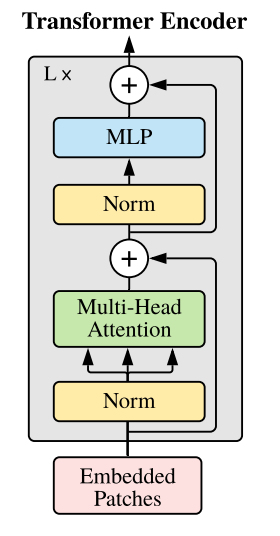

Энкодер состоит из
- Multi-Head Self Attention Layer(MSP) для линейного объединения нескольких выходов внимания в соответствии с ожидаемыми размерами. Несколько Multi-Head помогают изучать локальные и глобальные зависимости в изображении.
- Многослойные персептроны (MLP) содержат два слоя с GELU (Gaussian Error Linear Unit)
- Layer Norm (LN) применяется перед каждым блоком, так как она не вводит никаких новых зависимостей между обучающими изображениями. Помогает улучшить время обучения и производительность обобщения
- Residual connections применяются после каждого блока

Для классификации изображений классификация реализована с использованием MLP с одним скрытым слоем.
Верхние слои ViT изучают глобальные объекты, тогда как нижние слои изучают как глобальные, так и локальные объекты. Это позволяет ViT изучать более общие паттерны.


### Self-Attention
Будем работать со следующим предложением:

”The animal didn't cross the street because it was too tired”

Что означает it в этом предложении? It относится к улице или к животному? Когда модель обрабатывает слово it, self-attention позволяет ей ассоциировать it с animal, но it еще и связано с tired.

Self-attention позволяет нейросетке смотреть на другие слова во входной последовательности в поисках подсказок, которые могут помочь привести к лучшему кодированию этого слова.


<img src='http://jalammar.github.io/images/t/transformer_self-attention_visualization.png' width=400>


**Первый этап в вычислении self-attention** - создание трех векторов из каждого входного эмбеддинга. Для каждого слова создается вектор Query, Key и Value. Эти векторы создаются путем умножения эмбеддинга на три матрицы, которые обучаются.
- Query - слово, с которого смотрим на всё остальное
- Key - слово, на которое смотрим
- Value - здесь содержится смысл слова

<img src='http://jalammar.github.io/images/t/transformer_self_attention_vectors.png' width=500>

**Второй этап вычисления self-attention** – получение коэффициента (score). Коэффициент подсчитывается с помощью скалярного произведения вектора Query и вектора Key соответствующего слова. При перемножении Query на Key мы понимаем насколько слово с Key релевантно слову с Query.

<img src='http://jalammar.github.io/images/t/transformer_self_attention_score.png' width=500>

**Третий и четвертый этапы** – разделить коэффициенты на $\sqrt{d}$ (квадратный корень из размерности Key вектора; для того, чтобы были более стабильные градиенты), а затем пропустить результат через функцию софтмакс (softmax). Данная функция нормализует коэффициенты так, чтобы они были положительными и в сумме давали 1.

<img src='http://jalammar.github.io/images/t/self-attention_softmax.png' width=500>

**Пятый этап** – умножить каждый вектор значения (Value) на софтмакс-коэффициент.

**Шестой этап** – сложить взвешенные векторы значения. Это и будет представлять собой выход слоя внутреннего внимания в данной позиции (для первого слова).

<img src='http://jalammar.github.io/images/t/self-attention-output.png' width=500>


**Матричная краткая запись**

<img src='http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png' width=400>

### Multi-Head Self-Attention

Улучшает работу слоя внимания двумя способами:

1. Расширяет возможности модели фокусироваться на различных словах.

2. Дает слою внимания несколько “подпространств представления”. С Multi-Head self-attention есть несколько наборов весовых матриц query/key/value. Каждый из этих наборов инициализируется случайным образом. Затем, после обучения, каждый набор используется для проецирования входных вложений в другое подпространство представления.

<img src='http://jalammar.github.io/images/t/transformer_attention_heads_qkv.png' width=600>

<img src='http://jalammar.github.io/images/t/transformer_attention_heads_z.png' width=600>

<img src='http://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png' width=600>

<img src='http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png' width=400>






Ссылки:
1. [Vision Transformers: A New Computer Vision Paradigm](https://medium.com/swlh/visual-transformers-a-new-computer-vision-paradigm-aa78c2a2ccf2)
2. [Visual Transformers: Token-based Image Representation and Processing for Computer Vision](https://arxiv.org/pdf/2006.03677.pdf)
3. [Vision Transformer (ViT) - An image is worth 16x16 words | Paper Explained](https://www.youtube.com/watch?v=j6kuz_NqkG0)
4. [Прикладное машинное обучение 4. Self-Attention. Transformer overview](https://youtu.be/UETKUIlYE6g)

In [ ]:
import sys

package_path = '../input/vision-transformer-pytorch/VisionTransformer-Pytorch'
package_path2 = '../input/t2tvit'
package_path3 = '../input/timm-pytorch-image-models/pytorch-image-models-master'
sys.path.append(package_path)
sys.path.append(package_path2)
sys.path.append(package_path3)

In [ ]:
import os
import pandas as pd

import time
import datetime
import copy
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split


# ALBUMENTATIONS
import albumentations as albu

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
    
from albumentations.pytorch import ToTensorV2

In [ ]:
# BASE_DIR="../input/plant-pathology-2021-fgvc8/"
BASE_DIR = '../input/plant-pathology-2021-224x224/'
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train_imgs')

In [ ]:
train_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train_df.head()

In [ ]:
print("Count of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

In [ ]:
class_name = train_df['labels'].value_counts().index
class_count = train_df['labels'].value_counts().values

In [ ]:
display(train_df['labels'].nunique())
train_df.labels.value_counts()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_df, y='labels');

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df.labels)

In [ ]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        image = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))[:, ::-1]  # rgb img
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()
    

def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    img = cv2.imread(os.path.join(TRAIN_IAMGES_DIR, image_id))[:, ::-1] 
    plt.subplot(1, 3, 1)
    plt.imshow(img)
#     plt.axis('off')
    
    plt.subplot(1, 3, 2)
    x = transform(image=img)['image']
    plt.imshow(x)
#     plt.axis('off')
    
    plt.subplot(1, 3, 3)
    x = transform(image=img)['image']
    plt.imshow(x)
    
def visualize(images, transform):
    '''
    Plot images and their transformations
    '''
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

In [ ]:
# CUSTOM DATASET CLASS
class PlantDataset(Dataset):
    def __init__(
        self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image'])
        im = cv2.imread(im_path, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        if (self.transforms):
            im = self.transforms(image=im)['image']
            
        if (self.train):
            label = self.df.iloc[index]['labels']
            return im, label
        else:
            return im

In [ ]:
# AUGMENTATIONS

train_augs = albu.Compose([
    albu.RandomResizedCrop(height=224, width=224, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.3, 0.3, 0.3],
        std=[0.1, 0.1, 0.1],),
    CoarseDropout(p=0.5),
    Cutout(p=0.5),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=224, width=224, p=1.0),
    albu.Normalize(
        mean=[0.3, 0.3, 0.3],
        std=[0.1, 0.1, 0.1],),
    ToTensorV2(),
])


In [ ]:
# DATA SPLIT
train, valid = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df.labels.values
)

# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# targets in train,valid datasets
train_targets = train.labels.values
valid_targets = valid.labels.values

In [ ]:
# DEFINE PYTORCH CUSTOM DATASET
train_dataset = PlantDataset(
    df=train,
    imfolder=TRAIN_IMAGES_DIR,
    train=True,
    transforms=train_augs
)

valid_dataset = PlantDataset(
    df=valid,
    imfolder=TRAIN_IMAGES_DIR,
    train=True,
    transforms=valid_augs
)

In [ ]:
def plot_image_from_dataset(img_list):
    image_tensor = img_list[0]
    target = img_list[1]
    print(target)
    image = image_tensor.permute(1, 2, 0)
    plt.imshow(image)

In [ ]:
plot_image_from_dataset(train_dataset[7])

In [ ]:
# MAKE PYTORCH DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle = True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    num_workers=4,
    shuffle = False
)

In [ ]:
# TRAIN
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict()) # store best model weights
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('=' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            running_total = 0.0
            
            for step, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)

                # Zero out the grads
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward
                    outputs = model(inputs)
                    probabilities, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    # Backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += len(labels.data)
                
                if (step + 1) % 100 == 0:
                    print(f'[{step + 1}/{len(dataloaders[phase])}].')
                    print(f'Loss {running_loss / (step + 1)}. Accuracy {running_corrects / running_total}')
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    
    return model

### Training

In [ ]:
def load_state_dict(checkpoint_path, use_ema=False, num_classes=1000):
    if checkpoint_path and os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        state_dict_key = 'state_dict'
        if isinstance(checkpoint, dict):
            if use_ema and 'state_dict_ema' in checkpoint:
                state_dict_key = 'state_dict_ema'
        if state_dict_key and state_dict_key in checkpoint:
            new_state_dict = OrderedDict()
            for k, v in checkpoint[state_dict_key].items():
                # strip `module.` prefix
                name = k[7:] if k.startswith('module') else k
                new_state_dict[name] = v
            state_dict = new_state_dict
        else:
            state_dict = checkpoint
#         _logger.info("Loaded {} from checkpoint '{}'".format(state_dict_key, checkpoint_path))
#         if num_classes != 1000:
#             # completely discard fully connected for all other differences between pretrained and created model
#             del state_dict['head' + '.weight']
#             del state_dict['head' + '.bias']

        return state_dict
    else:
#         _logger.error("No checkpoint found at '{}'".format(checkpoint_path))
        raise FileNotFoundError()


def load_for_transfer_learning(model, checkpoint_path, use_ema=False, strict=False, num_classes=1000):
    state_dict = load_state_dict(checkpoint_path, use_ema, num_classes)
    model.load_state_dict(state_dict, strict=strict)


In [ ]:
stat = torch.load('../input/t2tvit/80.7_T2T_ViT_t_14.pth.tar')

del stat['state_dict_ema']['head.weight']
del stat['state_dict_ema']['head.bias']

torch.save(stat['state_dict_ema'],'80.7_T2T_ViT_t_14.pth.tar')

In [ ]:
from models.t2t_vit import *
# create model
model = T2t_vit_14(img_size=224, num_classes=12)
# load_for_transfer_learning(model, '80.7_T2T_ViT_t_14.pth.tar', num_classes=12)

In [ ]:
# # from vision_transformer_pytorch import VisionTransformer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# datasets = {'train': train_dataset,
#             'valid': valid_dataset}

# dataloaders = {'train': train_loader,
#                'valid': valid_loader}

# # LOAD PRETRAINED ViT MODEL
# # model = VisionTransformer.from_pretrained('ViT-B_16', num_classes=12)   

# # OPTIMIZER
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
# # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
# # optimizer = AdamP(model.parameters(), lr=1e-4, weight_decay=0.001)

# # LEARNING RATE SCHEDULER
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# criterion = nn.CrossEntropyLoss()
# num_epochs = 8

In [ ]:
# torch.save(model, 'full_plant_pathology_vit.pt')

In [ ]:
# len(dataloaders['train'])

In [ ]:
# # MODEL TRAIN
# trained_model = train_model(datasets, dataloaders,
#                             model, criterion,
#                             optimizer, scheduler,
#                             num_epochs, device)

In [ ]:
# Save the mode after training
# torch.save(trained_model, f't2t-vit-14_{num_epochs}_epoch.pth')

## Testing

In [ ]:
# from vision_transformer_pytorch import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# LOAD PRETRAINED ViT MODEL
model_path = '../input/t2t-vit-14/t2t-vit-14_3_epoch.pt'
model = torch.load(model_path)
# model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
from pathlib import Path

df_preds = pd.DataFrame()
for path in Path('../input/plant-pathology-2021-fgvc8/test_images').iterdir():
    img = cv2.imread(str(path))[:, ::-1]
    img = valid_augs(image=img)['image'].cuda()
    pred = model(img[None])
    
    df_preds = df_preds.append(
        {'image': path.parts[-1], 'labels': le.inverse_transform(torch.argmax(pred.cpu(), dim=1))[0]},
        ignore_index=True)
    
df_preds

In [ ]:
df_preds.to_csv('submission.csv', index=False)

Полезные ссылки:
1. [Swin-Transformer](https://github.com/microsoft/Swin-Transformer)
2. [VisionTransformer-Pytorch](https://github.com/tczhangzhi/VisionTransformer-PyTorch)
3. [vit-pytorch](https://github.com/lucidrains/vit-pytorch)